<a href="https://colab.research.google.com/github/BDouchet/SDATA/blob/main/TP_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and load dataset

Iris dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1FIIo3FFl9VTavlLfk1c_OAyF00eOZ336'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('iris.csv')

# Read dataset into a dataframe



In [2]:
df=pd.read_csv('iris.csv')
print(df.dtypes)
df

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety          object
dtype: object


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


# Data Visualization

In [3]:
df.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Plot of the scatter between pairs of features. Diagonal plots represent the frequency of each value in the feature range.

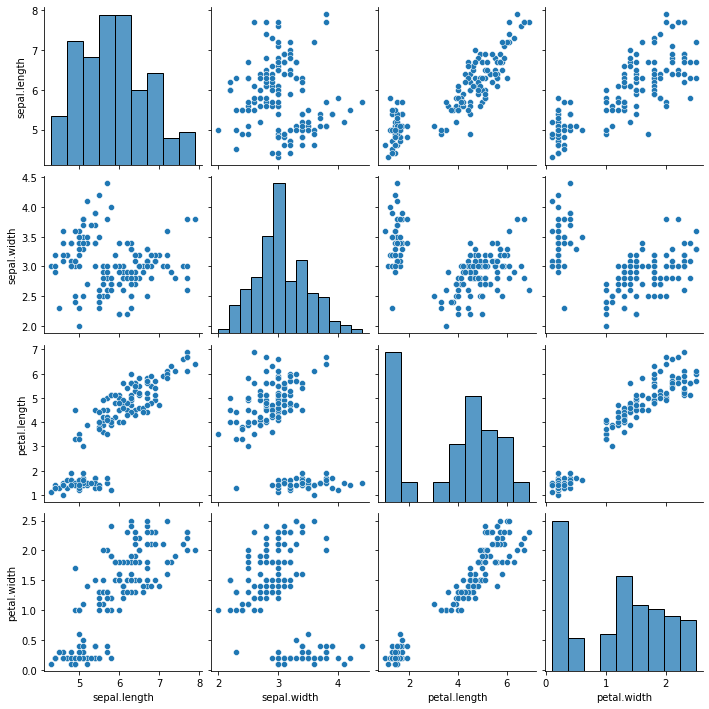

In [4]:
sns.pairplot(df)

Application of TSNE (T-distributed Stochastic Neighbor Embedding). According to [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) :
> It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

Thus, it allows to visualize images in 2D (or 3D) by applying dimension reduction. A low or a high perplexity usually results in bad projection of the values. Recommended values are between 5 and 50.

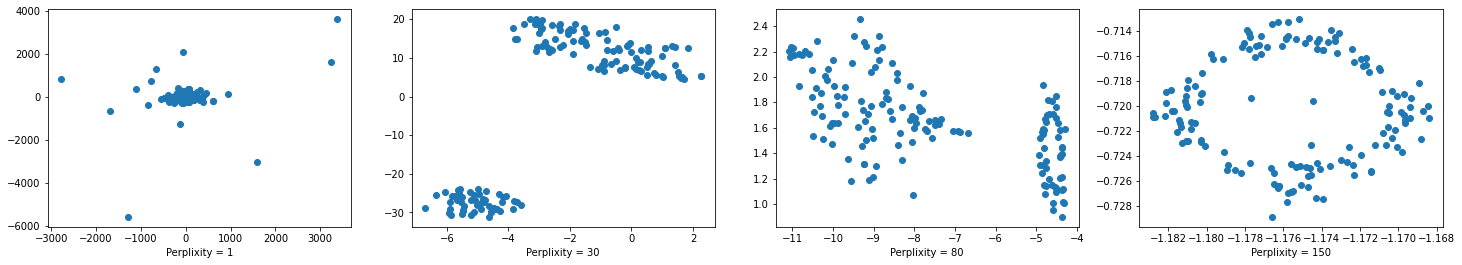

In [91]:
from sklearn.manifold import TSNE

perplexities=[1,30,80,150]

_,axs=plt.subplots(ncols=4,nrows=1,figsize=(25,4))
for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    df_embed=TSNE(perplexity=perplexities[i]).fit_transform(df[df.columns[:-1]])
    ax.scatter(df_embed[:,0],df_embed[:,1])
    ax.set_xlabel('Perplixity = '+str(perplexities[i]))

# Preprocessing

Process of the data to be exloitable by algorithms :
1.   Split in X and Y
2.   Convert from label names to label index



In [95]:
X=df[df.columns[:-1]].to_numpy()
Y=df['variety'].to_numpy()

print(X.shape,Y.shape)

(150, 4) (150,)


In [96]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
Y_lab=le.fit_transform(Y)
print(le.classes_)
unique, counts = np.unique(Y_lab, return_counts=True)
dict(zip(unique, counts))

['Setosa' 'Versicolor' 'Virginica']


{0: 50, 1: 50, 2: 50}

# Manual LDA

Linear Discriminant Analysis (LDA) calculated manually. Comparison of the results with sklearn.discriminant analysis.LinearDiscriminantAnalysis.

**Calculation of the within-class scatter matrix**

I first calculate the mean of each features in the three classes `m0,m1,m2` and the mean of the features over all the classes `m`.

Then, I calculate `sub0,sub1,sub2` which represents the spread in each class for each feature. The dispersion is calculated as the difference between a value and its mean.

`s0,s1,s2` are the matrix calculated by the element-wise sum of the matrix product between the previous calculated spreads.

`sw`, the within-class matrix, is calculated with the sum (element-wise) of the previous matrix. 


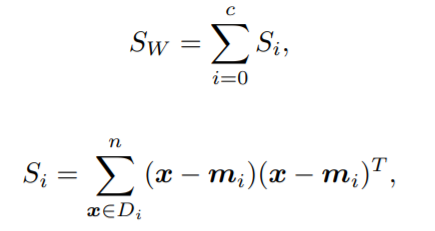

In [97]:
m0,m1,m2=X[:50].mean(axis=0),X[50:100].mean(axis=0),X[100:].mean(axis=0) # mean of the features in each class
m=X.mean(axis=0) # mean of the features in all classes

# spread of each feature in each class
sub0,sub1,sub2=np.array([X[i]-m0 for i in range(50)]),np.array([X[i]-m1 for i in range(50,100)]),np.array([X[i]-m2 for i in range(100,150)])

# intermediary matrix to calculate the within-class matrix
s0,s1,s2=np.sum([np.outer(sub,sub.T) for sub in sub0],axis=0),np.sum([np.outer(sub,sub.T) for sub in sub1],axis=0),np.sum([np.outer(sub,sub.T) for sub in sub2],axis=0)

# within-class matrix
sw=np.sum([s0,s1,s2],axis=0)
sw

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

**Calculation of the betwen-class matrix**

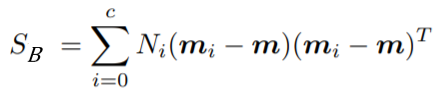

with `m0,m1,m2`the previous mean of each class of each feature and `m`the mean of each feature over all the classes. 

In [98]:
mis=[m0,m1,m2]
sb=np.sum([50*np.outer(mi-m,mi-m) for mi in mis],axis=0)
sb

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

**Eigenvalues and their associated Eigenvectors**

Calculation of the eigenvalues of the matrix `inv(sw) * sb`. We keep the highest eigenvalues because they explain the biggest part of the data. The first two eigenvalues (F1 and F2) explains more than 99% of the data.

In [102]:
print('Matrix inv(sw) * sb :')
prod=np.linalg.inv(sw) @ sb
print(prod)
print()

print("Eigen values sorted :")
eigen_values,eigen_vectors=np.linalg.eig(prod)
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])
print()


eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Matrix inv(sw) * sb :
[[ -3.05836939   1.08138264  -8.1119227   -3.45864987]
 [ -5.56163926   2.17821866 -14.96461194  -6.30773951]
 [  8.07743878  -2.94271854  21.5115909    9.14206468]
 [ 10.49708187  -3.41985449  27.54852482  11.84588007]]

Eigen values sorted :
32.191929198278025
0.28539104262306675
4.959432720746535e-15
8.530239058578782e-16

Explained Variance
Eigenvector 0: 0.9912126049653671
Eigenvector 1: 0.008787395034632587
Eigenvector 2: 1.5270449298032764e-16
Eigenvector 3: 2.6265218297893983e-17


**Projection**

Projection of the dataset over the plane made of F1 and F2

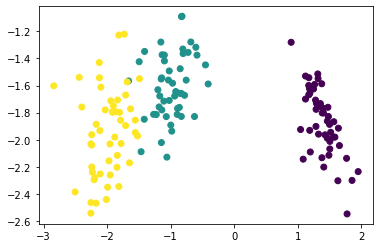

In [101]:
w_matrix = np.hstack((pairs[0][1].reshape(4,1), pairs[1][1].reshape(4,1))).real

X_trans=X @ w_matrix

plt.scatter(X_trans[:,0],X_trans[:,1],c=Y_lab)
plt.show()

**Comparison with LinearDiscriminantAnalysis in sklearn**

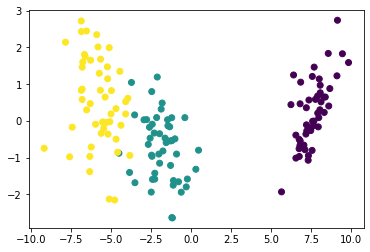

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis(n_components=2)
X_trans=lda.fit_transform(X,Y_lab)
plt.scatter(X_trans[:,0],X_trans[:,1],c=Y_lab)
plt.show()

**Creation of the predictor**

The predictor is calculated as follow :

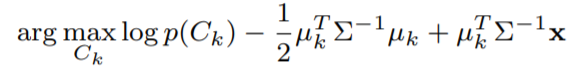

with mu_k=`mi`, and sigma the sum of the covariance matrix of each class.

In [113]:
import math

def predict(x):
    cks=[]
    cov0,cov1,cov2=np.cov(X[:50].T),np.cov(X[50:100].T),np.cov(X[100:].T)
    cov=np.sum([cov0,cov1,cov2],axis=0)/3
    for i in range(3):
        mi=mis[i]
        ck=x @ np.linalg.inv(cov) @ mi[:,np.newaxis] - 0.5 * mi @ np.linalg.inv(cov) @ mi[:,np.newaxis]
        cks.append(ck+np.argmax(math.log(1/3)))
    ind=np.argmax(np.array(cks))
    return ind,le.classes_[ind]

print(predict(X[10]))
print(predict(X[60]))
print(predict(X[100]))

(0, 'Setosa')
(1, 'Versicolor')
(2, 'Virginica')


An horizontal line signifies they are no errors. It is easy to spot the errors in this classification. We observe we obtain the same values with sklearn LDA.

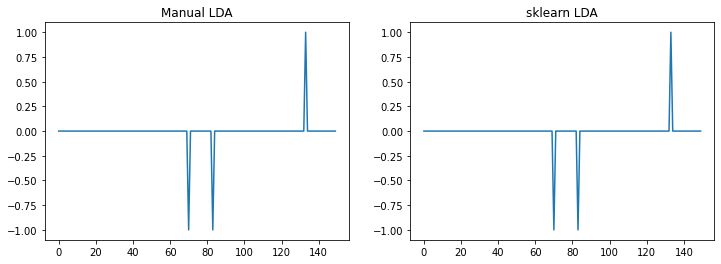

In [121]:
_,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
yhat=[predict(x)[0] for x in X]
ax1.plot(Y_lab-yhat)
ax1.set_title("Manual LDA")
yhat=lda.predict(X)
ax2.plot(Y_lab-yhat)
ax2.set_title("sklearn LDA")
plt.show()

#Train_test_split vs K-fold

A small comparison between train_test_split and K_fold learning phase with the f1_score metric

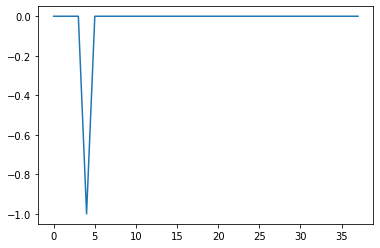

0.975983436853002


array([[ 9,  0,  0],
       [ 0, 11,  1],
       [ 0,  0, 17]])

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix

X_train,X_test,Y_train,Y_test=train_test_split(X,Y_lab,test_size=0.25)
lda=LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train,Y_train)
Yhat_test=lda.predict(X_test)

plt.plot(Y_test-Yhat_test)
plt.show()

print(f1_score(Y_test,Yhat_test,average='macro'))

confusion_matrix(Y_test,Yhat_test)

In [130]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(shuffle=True)
skf.get_n_splits(X,Y_lab)
f1=[]
for train_index, test_index in skf.split(X, Y_lab):
    X_train,X_test=X[train_index],X[test_index]
    Y_train,Y_test=Y[train_index],Y[test_index]
    lda=LinearDiscriminantAnalysis(n_components=2)
    lda.fit(X_train,Y_train)
    Yhat_test=lda.predict(X_test)
    f1.append(f1_score(Y_test,Yhat_test,average='macro'))
print(f1)
print(np.array(f1).mean())

[0.9665831244778613, 0.9665831244778613, 1.0, 1.0, 0.9665831244778613]
0.9799498746867169


# Draw decision boundaries

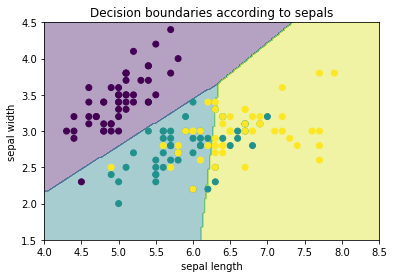

In [134]:
lda.fit(X[:,:2],Y_lab)

xx,yy,= np.meshgrid(np.linspace(4, 8.5, 200), np.linspace(1.5, 4.5, 200))
Z=lda.predict(np.c_[xx.ravel(),yy.ravel()])
Z=Z.reshape((200,200))

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=Y_lab)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.title('Decision boundaries according to sepals')
plt.show()

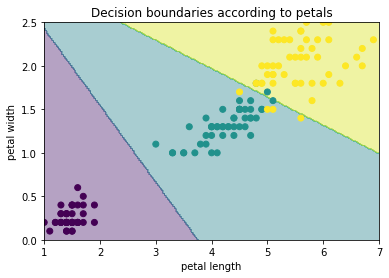

In [135]:
lda.fit(X[:,2:],Y_lab)

xx,yy,= np.meshgrid(np.linspace(1, 7, 200), np.linspace(0, 2.5, 200))
Z=lda.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape((200,200))

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 2], X[:, 3], c=Y_lab)

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.title('Decision boundaries according to petals')

plt.show()